In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [3]:
iris = load_iris()
X = iris.data[:,2:] #petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(X,y)

DecisionTreeClassifier(max_depth=2)

In [4]:
from sklearn.tree import export_graphviz
export_graphviz(tree_clf,
                out_file = 'iris_tree.dot',
                feature_names = iris.feature_names[2:],
                class_names = iris.target_names,
                rounded=True,
                filled=True)

In [6]:
print(tree_clf.predict_proba([[5,1.5]]))
print(tree_clf.predict([[5,1.5]]))


[[0.         0.90740741 0.09259259]]
[1]


## Regression with Decision Trees

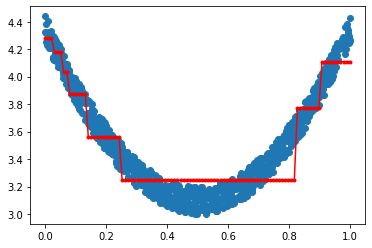

In [56]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt
import random

x = np.random.rand(1000,1)
y = 5 * (x-0.5) ** 2 + 3 + np.random.rand(1000,1)/5

tree_reg = DecisionTreeRegressor(max_depth=3)
tree_reg.fit(x,y)

export_graphviz(tree_reg,out_file='rand_sq.dot',feature_names=["x1"],rounded=True,filled=True)


x_pred = np.linspace(x.min(),x.max(),100)
plt.plot(x_pred,tree_reg.predict(x_pred.reshape(-1,1)),"r.-")
plt.scatter(x,y)



## Issues with Decision Trees: Sensitivity to Orientation

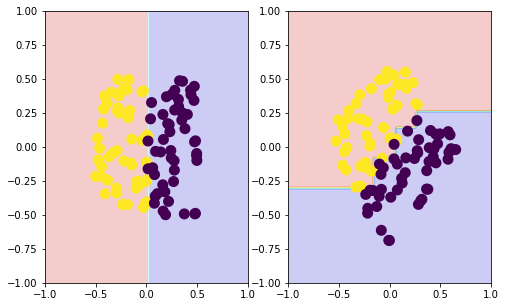

In [120]:
plt.figure(figsize=(8,5))
## Generate the training data 
x1 = np.sort(np.random.rand(100) - .5)
x2 = np.random.rand(100) - .5
X = np.c_[x1, x2]
y = np.r_[np.ones(50), np.zeros(50)].reshape(-1,1)

## Generate the decision boundary
my_tree = DecisionTreeClassifier(max_depth=2)
my_tree.fit(X,y)


## Plot the plane for the predictions
xt = np.linspace(-1,1,100)
x1g,x2g = np.meshgrid(xt,xt)

preds = my_tree.predict(np.c_[x1g.ravel(),x2g.ravel()]).reshape(x1g.shape)

plt.subplot(121)
plt.contourf(x1g,x2g,preds,alpha = 0.2,cmap = 'jet')
plt.scatter(x1,x2,c = y,linewidth=5)


deg = -45
rot_func = lambda a,b : [a*np.cos(np.radians(deg))-b*np.sin(np.radians(deg)) , 
                         a*np.sin(np.radians(deg)) + b*np.cos(np.radians(deg))]
x1n,x2n = rot_func(x1,x2)
Xn = np.c_[x1n,x2n]

my_tree = DecisionTreeClassifier(max_depth=4)
my_tree.fit(Xn,y)

new_preds =  my_tree.predict(np.c_[x1g.ravel(),x2g.ravel()]).reshape(x1g.shape)

plt.subplot(122)
plt.contourf(x1g,x2g, new_preds,alpha = 0.2,cmap = 'jet')
plt.scatter(x1n,x2n,c = y,linewidth =5)




## Exercise 7: GridSearch on the Make Moons dataset

In [161]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons

##Generate the dataset and split into train and test
data = make_moons(n_samples = 10000,noise =0.4)
X = data[0]
y = data[1]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

##Define classifier and identify the parameters to test
moon_tree = DecisionTreeClassifier()
params = {'max_depth':range(2,20),'max_leaf_nodes': 2**np.arange(1,10),'min_samples_leaf': [0.1 , 0.2, 0.5, 1]}

##Perform the grid search
mygrid = GridSearchCV(moon_tree,params,cv = 5,verbose = True)
mygrid.fit(X_train,y_train)

##Make the predictions on the test dataset
y_pred = mygrid.predict(X_test)
test_score = accuracy_score(y_test,y_pred)


##Print the results
print('Best parameters: ' + str(mygrid.best_params_))
print('Training best score: ' + str(mygrid.best_score_))
print('Testing score: ' + str(test_score))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters: {'max_depth': 8, 'max_leaf_nodes': 32, 'min_samples_leaf': 1}
Training best score: 0.858625
Testing score: 0.862


## Exercise 8: Generation of a Random Forest

In [178]:
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone
from scipy.stats import mode

shuffler = ShuffleSplit(n_splits=1000,test_size = len(X_train) - 100,random_state = 42)

models = []
orig_test = []
for model_id,(train_indx, test_indx) in enumerate(shuffler.split(X_train)):
    
    x_sub_train,y_sub_train = X[train_indx,:], y[train_indx] #create train sets of 100 samples long
    x_sub_test,y_sub_test = X[test_indx,:], y[test_indx]
    
    #instantiate models with the best parameters from EX7
    models.append(DecisionTreeClassifier(**mygrid.best_params_).fit(x_sub_train,y_sub_train))
    y_pred = models[model_id].predict(x_sub_test) #look at test (should be ~80%)
    
    orig_test.append(models[model_id].predict(X_test)) #predict on original, stack on list to verify all later
    
    if model_id % 50 == 0: #sample the accuracy periodically
        print(f'Training score for model {model_id}: ' + str(accuracy_score(y_sub_test,y_pred))) 
        
#Reshape the predictions on the testing as a 2D array, and find the majority vote
full_test = np.array(orig_test).T.reshape(len(y_test),-1) 
forest_preds = mode(full_test,axis=1)[0].reshape(-1,)

#Output the full testing score
print('Original testing score: ' + str(accuracy_score(y_test,forest_preds)))
    
    

Training score for model 0: 0.7855696202531646
Training score for model 50: 0.7837974683544304
Training score for model 100: 0.7986075949367089
Training score for model 150: 0.7656962025316456
Training score for model 200: 0.8232911392405063
Training score for model 250: 0.8316455696202532
Training score for model 300: 0.7491139240506329
Training score for model 350: 0.7626582278481012
Training score for model 400: 0.7954430379746835
Training score for model 450: 0.7803797468354431
Training score for model 500: 0.8017721518987342
Training score for model 550: 0.7824050632911392
Training score for model 600: 0.830379746835443
Training score for model 650: 0.7962025316455696
Training score for model 700: 0.7962025316455696
Training score for model 750: 0.7927848101265823
Training score for model 800: 0.7822784810126582
Training score for model 850: 0.7529113924050633
Training score for model 900: 0.8117721518987342
Training score for model 950: 0.7977215189873418
Original testing score: 